## look at AF spectra differences between pc and eqtls

pcqtls tend to be lower allele frequency than eqlts

this is true for middle and last pcs, not so much for 1st pcs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress
import upsetplot as up



from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

#tissue_ids = ['Adipose_Subcutaneous']
tissue_ids = tissue_ids[:11]

## on top per cluster

#### load in data

In [3]:
pcqtls = load_across_tissues(config, load_pc_cis)
pcqtls['type'] = 'pcqtl'

eqtls = load_across_tissues(config, load_e_cis)
eqtls['pc_num'] = 0
eqtls['cluster_size'] = eqtls['cluster_id'].str.split('_').apply(len)
eqtls['type'] = 'eqtl'
eqtls['pc_order'] = 'eqtl'


qtls = pd.concat([pcqtls, eqtls]).reset_index()
qtls['minor_af'] = np.where(qtls['af']>.5, 1-qtls['af'], qtls['af'])
qtls = qtls[qtls['qval'] < .05]

In [4]:
# group by lead variant to prevent varaints from being double counted
qtls_grouped = qtls.groupby(['variant_id', 'tissue_id', 'cluster_id']).agg({'phenotype_id':list, 
                                                                                'minor_af':'first', 
                                                                                'qval':list, 
                                                                                'pval_perm':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list}).reset_index() # you could also do a list of varainces
qtls_grouped['num_e_samelead'] = qtls_grouped['phenotype_id'].astype(str).str.count('_e')
qtls_grouped['num_pc_samelead'] = qtls_grouped['phenotype_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

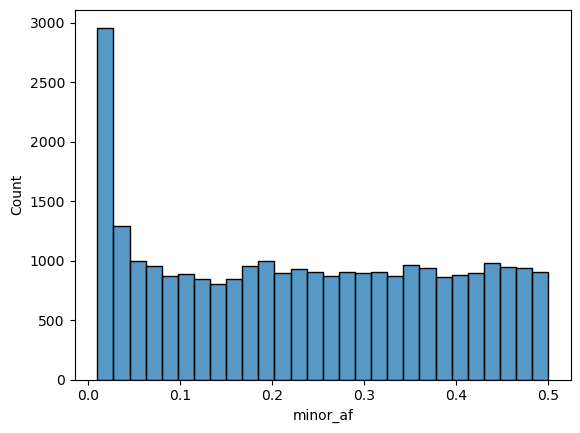

In [5]:
sns.histplot(qtls_grouped, x='minor_af')
plt.show()

Text(0.5, 0, 'Minor allele frequency')

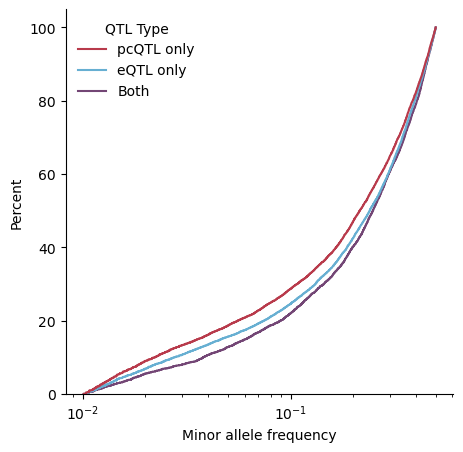

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

sns.ecdfplot(data=qtls_grouped, x='minor_af', hue='exclusive_label', stat="percent", log_scale=True, ax=ax,
             palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

ax.set_xlabel('Minor allele frequency')


In [174]:
# Example data
from scipy import stats

# Mann-Whitney U Test
stat, p_value = stats.mannwhitneyu(qtls_grouped[qtls_grouped['exclusive_label']=='pcqtl_only']['minor_af'], qtls_grouped[qtls_grouped['exclusive_label']=='eqtl_only']['minor_af'])

print(f"Mann-Whitney U Test: stat={stat}, p-value={p_value}")

Mann-Whitney U Test: stat=58615624.0, p-value=5.374108394501277e-13


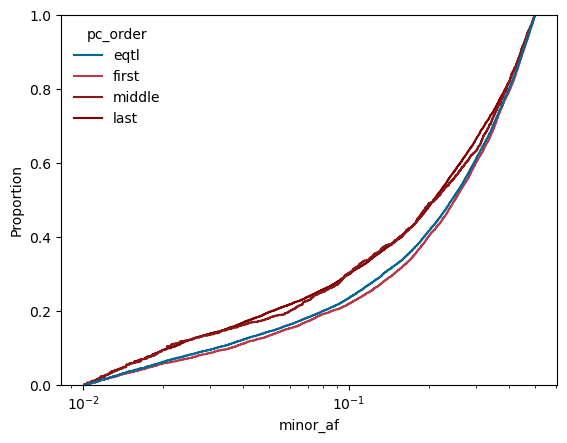

In [25]:
qtls_explode = qtls_grouped.explode('pc_order')
sns.ecdfplot(data=qtls_explode, x='minor_af', hue='pc_order', stat="proportion", log_scale=True, 
             palette={'first':'#B83A4B', 'middle':'#8C1515', 'last':'#820000', 'eqtl':'#016895'}, hue_order=['eqtl', 'first', 'middle', 'last'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('PC order')


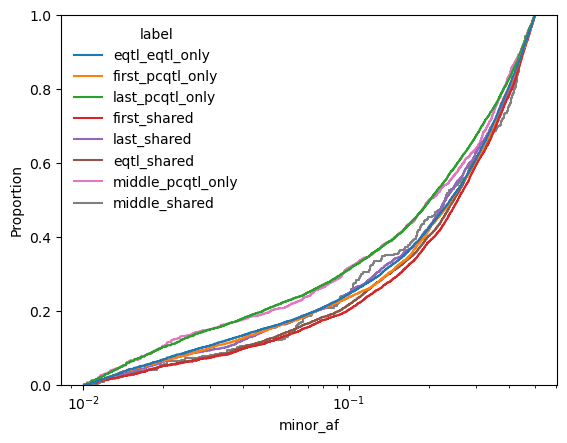

In [26]:
qtls_explode['label'] = qtls_explode['pc_order'].astype(str) + '_' + qtls_explode['exclusive_label'].astype(str)
sns.ecdfplot(data=qtls_explode, x='minor_af', hue='label', stat="proportion", log_scale=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('PC order')

## susie, pip weighted version

In [8]:
pc_susie = load_across_tissues(config, load_pc_susie)
annotate_pc_order(pc_susie)
pc_susie['type'] = 'pcqtl'


e_susie = load_across_tissues(config, load_e_susie)
e_susie['pc_num'] = 0
e_susie['cluster_size'] = e_susie['cluster_id'].str.split('_').apply(len)
e_susie['type'] = 'eqtl'
e_susie['pc_order'] = 'eqtl'


susie = pd.concat([pc_susie, e_susie]).reset_index(drop=True)
susie['minor_af'] = np.where(susie['af']>.5, 1-susie['af'], susie['af'])

susie['pip_weighted_af'] = susie['minor_af'] * susie['pip']

In [9]:
# add the lead var af as a column
lead_var_afs = susie[susie['lead_variant_id'] == susie['variant_id']].groupby(['lead_variant_id', 'tissue_id']).agg({'minor_af':'first'}).drop_duplicates()
susie = pd.merge(susie, lead_var_afs, left_on=['lead_variant_id', 'tissue_id'], right_on=['lead_variant_id', 'tissue_id'], how='left', suffixes=['', '_lead_var'])

In [10]:
# get pip weighted afs per credible set
susie_cs_grouped = susie.groupby(['cs_id', 'tissue_id']).agg({'lead_variant_id':'first', 
                                               'pip_weighted_af':sum,
                                               'minor_af':min,
                                               'phenotype_id':'first', 
                                               'pc_order':'first',
                                               'type':'first', 
                                               'cluster_id':'first', 
                                               'minor_af_lead_var':'first', 
                                               'pip':sum, 
                                               'cs_num':'first'})

<AxesSubplot: xlabel='pip', ylabel='Count'>

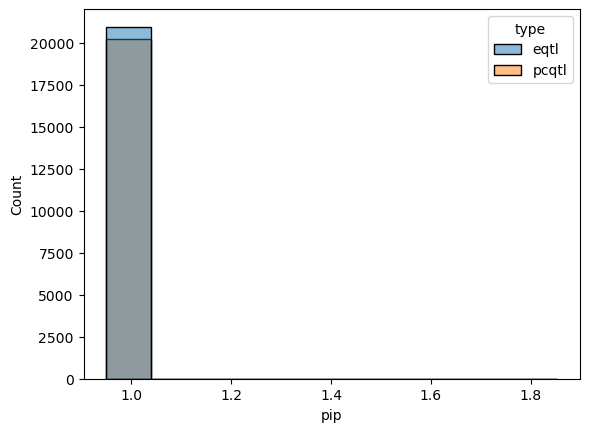

In [11]:
sns.histplot(susie_cs_grouped, x='pip', hue='type', bins=10)

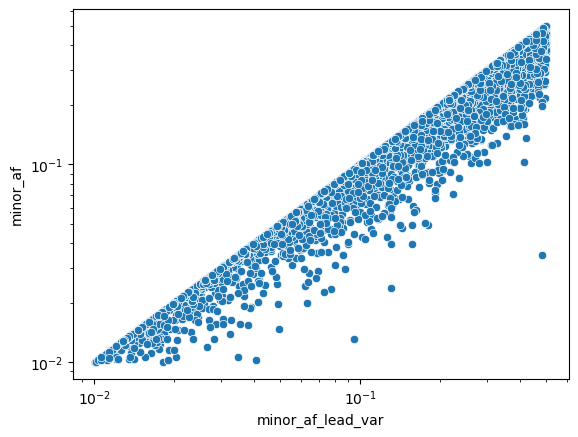

In [12]:
ax = sns.scatterplot(susie_cs_grouped, x='minor_af_lead_var', y='minor_af')
ax.set_xscale('log')
ax.set_yscale('log')

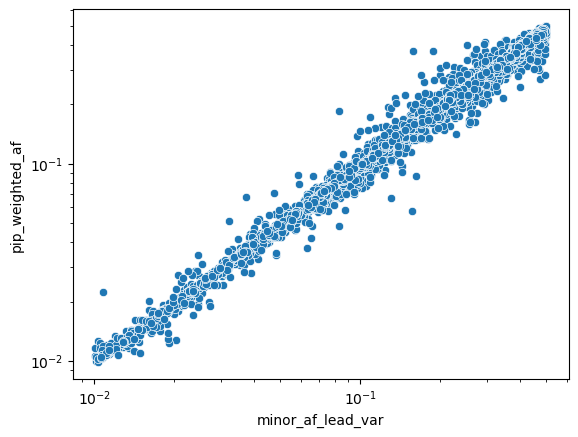

In [13]:
ax = sns.scatterplot(susie_cs_grouped, x='minor_af_lead_var', y='pip_weighted_af')
ax.set_xscale('log')
ax.set_yscale('log')

In [14]:
# group by lead variant to prevent varaints from being double counted
susie_lead_var_grouped = susie_cs_grouped.reset_index().groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'phenotype_id':list, 
                                                                                                       'cs_id':'first', 
                                                                                                       'type':list, 
                                                                                                       'pc_order':list, 
                                                                                                       'minor_af':min,
                                                                                                       'pip_weighted_af':min, 
                                                                                                       'minor_af_lead_var':'first', 
                                                                                                       'cs_num':list}).reset_index() # you could also do a list of varainces
susie_lead_var_grouped['num_e_samelead'] = susie_lead_var_grouped['phenotype_id'].astype(str).str.count('_e')
susie_lead_var_grouped['num_pc_samelead'] = susie_lead_var_grouped['phenotype_id'].astype(str).str.count('_pc')
susie_lead_var_grouped['exclusive_label'] = np.where((susie_lead_var_grouped['num_e_samelead'] > 0), np.where((susie_lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

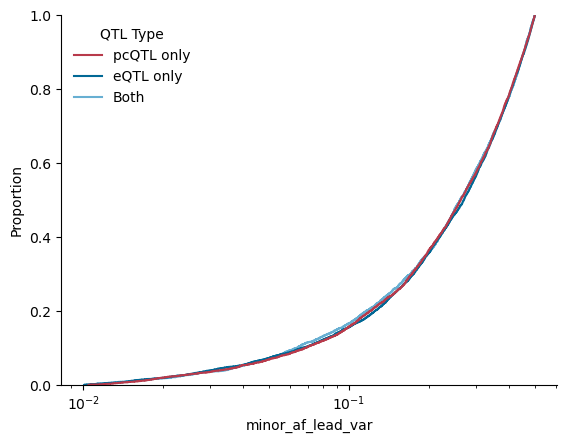

In [15]:
ax = sns.ecdfplot(data=susie_lead_var_grouped, x='minor_af_lead_var', hue='exclusive_label', stat="proportion", log_scale=True, 
             palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#016895', 'shared':'#67AFD2'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

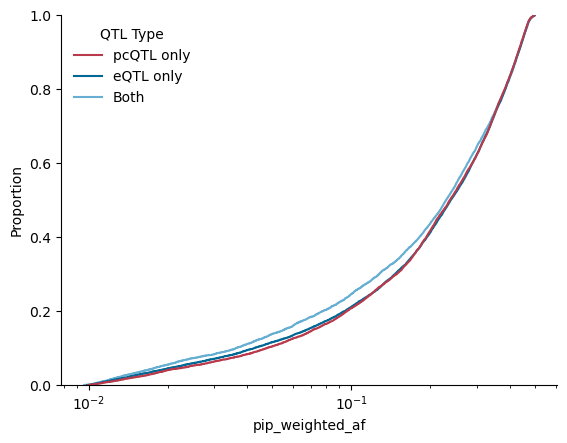

In [16]:
ax = sns.ecdfplot(data=susie_lead_var_grouped, x='pip_weighted_af', hue='exclusive_label', stat="proportion", log_scale=True, 
             palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#016895', 'shared':'#67AFD2'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

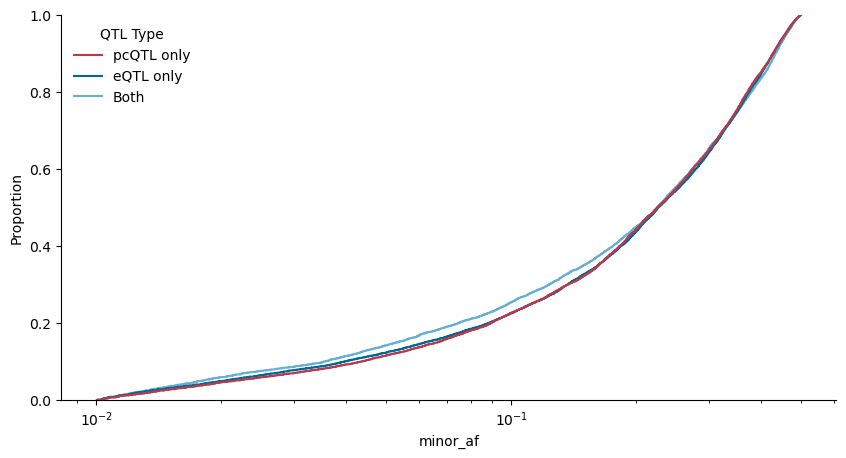

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.ecdfplot(data=susie_lead_var_grouped, x='minor_af', hue='exclusive_label', stat="proportion", log_scale=True, ax=ax,
             palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#016895', 'shared':'#67AFD2'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

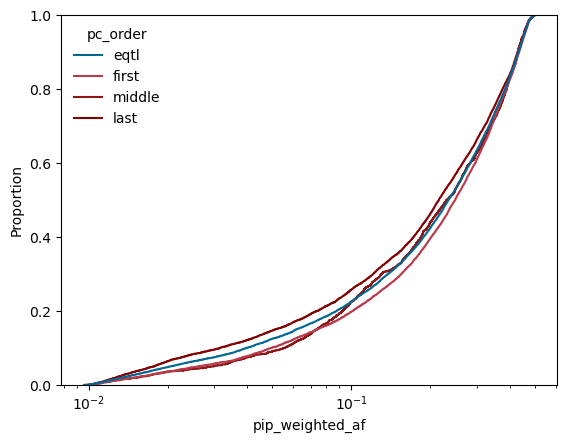

In [18]:
susie_lead_var_grouped_explode = susie_lead_var_grouped.explode('pc_order')
sns.ecdfplot(data=susie_lead_var_grouped_explode, x='pip_weighted_af', hue='pc_order', stat="proportion", log_scale=True, 
             palette={'first':'#B83A4B', 'middle':'#8C1515', 'last':'#820000', 'eqtl':'#016895'}, hue_order=['eqtl', 'first', 'middle', 'last'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('PC order')


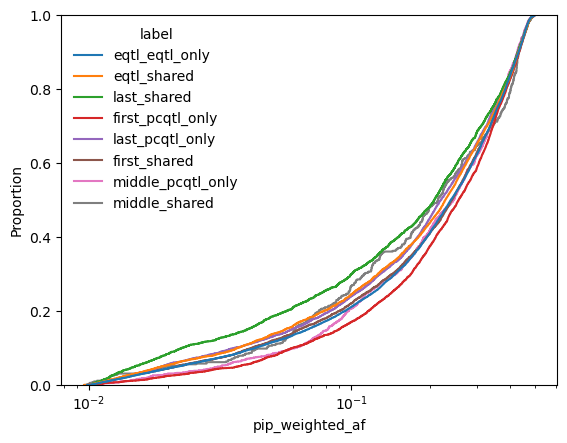

In [19]:
susie_lead_var_grouped_explode['label'] = susie_lead_var_grouped_explode['pc_order'].astype(str) + '_' + susie_lead_var_grouped_explode['exclusive_label'].astype(str)
sns.ecdfplot(data=susie_lead_var_grouped_explode, x='pip_weighted_af', hue='label', stat="proportion", log_scale=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)


# Change legend title
leg = ax.get_legend()
leg.set_title('PC order')